In [17]:
# This code cell only needed if you are running a GPU and get an error about BLAS operations

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Memory growth must be set before GPUs have been initialized
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

Num GPUs Available:  0


# The data

In [18]:
import os, shutil, pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [7]:
base_dir = pathlib.Path("C:/Users/Danielle/Downloads/cats_vs_dogs_small")


train_ds = image_dataset_from_directory(
    base_dir / "train", 
    image_size=(180, 180),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    base_dir / "validation", 
    image_size=(180, 180),
    batch_size=32
)

test_ds = image_dataset_from_directory(
    base_dir / "test", 
    image_size=(180, 180),
    batch_size=32
)


Found 2000 files belonging to 2 classes.
Found 545 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [8]:
for imgs, labs in train_ds:
  print(imgs.shape)
  print(labs.shape)
  break

(32, 180, 180, 3)
(32,)


# From scratch

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = ModelCheckpoint(
                filepath="convnet_from_scratch.keras",
                save_best_only=True,
                monitor="val_loss"
)

history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[callbacks])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5540

ValueError: The following argument(s) are not supported with the native Keras format: ['options']

In [20]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [12]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_ds)

print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 69ms/step - loss: 0.6134 - accuracy: 0.6985
Test accuracy: 0.698


# Data augmentation

In [21]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(
        height_factor=0.1,
        width_factor=0.2,
        fill_mode="nearest")])

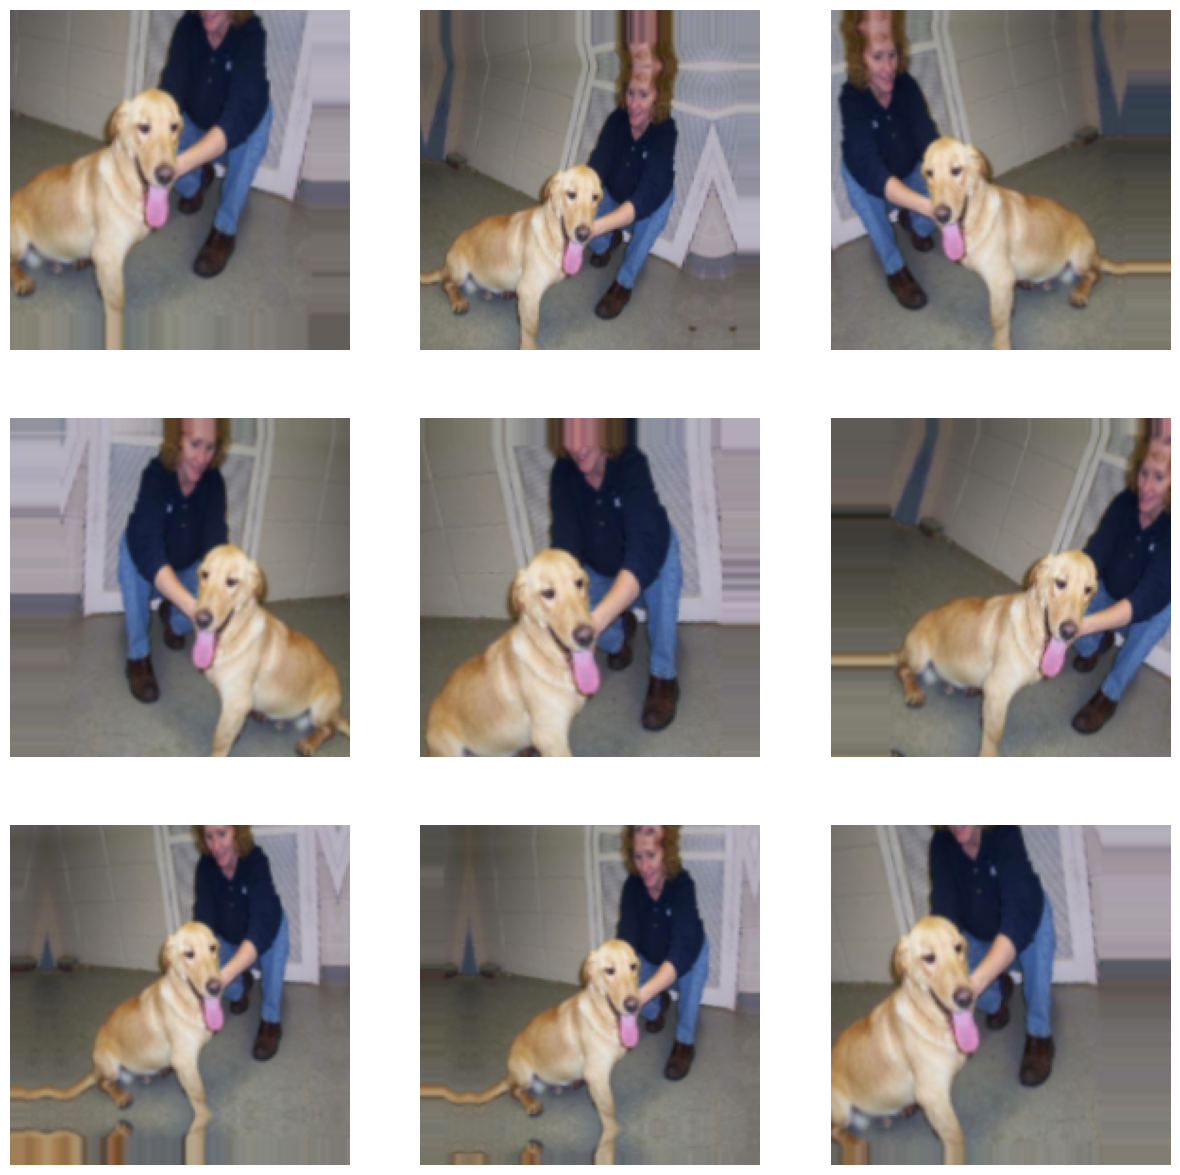

In [22]:
plt.figure(figsize=(15, 15))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [23]:
model_2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [24]:
callbacks = keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch_with_augmentation.keras",
                                            save_best_only=True,
                                            monitor="val_loss")

history_2 = model_2.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 205ms/step - loss: 0.8187 - accuracy: 0.4990 - val_loss: 0.6928 - val_accuracy: 0.5030
Epoch 2/30
63/63 [==============================] - 13s 209ms/step - loss: 0.6988 - accuracy: 0.5350 - val_loss: 0.9283 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 14s 221ms/step - loss: 0.7043 - accuracy: 0.5420 - val_loss: 0.6903 - val_accuracy: 0.5050
Epoch 4/30
63/63 [==============================] - 14s 215ms/step - loss: 0.7011 - accuracy: 0.5720 - val_loss: 0.6558 - val_accuracy: 0.5960
Epoch 5/30
63/63 [==============================] - 14s 221ms/step - loss: 0.7207 - accuracy: 0.5865 - val_loss: 0.6560 - val_accuracy: 0.6020
Epoch 6/30
63/63 [==============================] - 14s 216ms/step - loss: 0.6592 - accuracy: 0.6240 - val_loss: 0.6472 - val_accuracy: 0.6430
Epoch 7/30
63/63 [==============================] - 13s 207ms/step - loss: 0.6464 - accuracy: 0.6370 - val_loss: 0.6480 - val_accuracy: 0.6020

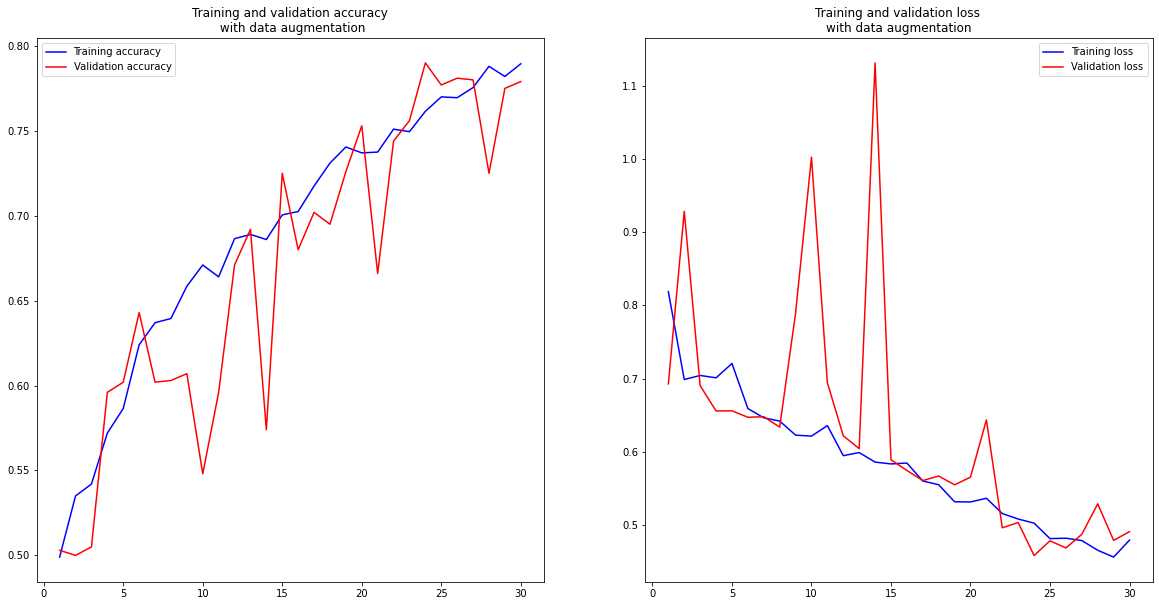

In [25]:
accuracy = history_2.history["accuracy"]
val_accuracy = history_2.history["val_accuracy"]
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy\n with data augmentation")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss \nwith data augmentation")
plt.legend()
plt.show()

In [26]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_ds)

print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 69ms/step - loss: 0.4868 - accuracy: 0.7610
Test accuracy: 0.761


# Pretrained model

# Feature extraction

<img src="Pretrained-1.jpg" width=800 align="center">

In [27]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(include_top=False, 
                  weights="imagenet",
                  input_shape=(180, 180, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [28]:
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(train_ds)
val_features, val_labels = get_features_and_labels(val_ds)
test_features, test_labels = get_features_and_labels(test_ds)

In [30]:
train_features.shape

(2000, 5, 5, 512)

In [31]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = keras.Model(inputs, outputs)
model_3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               1638528   
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,638,657
Trainable params: 1,638,657
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_3.compile(loss="binary_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])

callbacks = keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras",
                                            save_best_only=True,
                                            monitor="val_loss")


history_3 = model_3.fit(train_features, 
                    train_labels,
                    epochs=20,
                    validation_data=(val_features, val_labels),
                    callbacks=[callbacks])

Epoch 1/20
63/63 [==============================] - 2s 18ms/step - loss: 3.5432 - accuracy: 0.9185 - val_loss: 0.3498 - val_accuracy: 0.9580
Epoch 2/20
63/63 [==============================] - 1s 15ms/step - loss: 0.4778 - accuracy: 0.9695 - val_loss: 0.8566 - val_accuracy: 0.9530
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 0.1454 - accuracy: 0.9900 - val_loss: 0.3317 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 0.0167 - accuracy: 0.9980 - val_loss: 0.5496 - val_accuracy: 0.9670
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 0.0333 - accuracy: 0.9960 - val_loss: 0.6039 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 0.0162 - accuracy: 0.9990 - val_loss: 0.5547 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.0148 - accuracy: 0.9980 - val_loss: 0.5800 - val_accuracy: 0.9740
Epoch 8/20
63

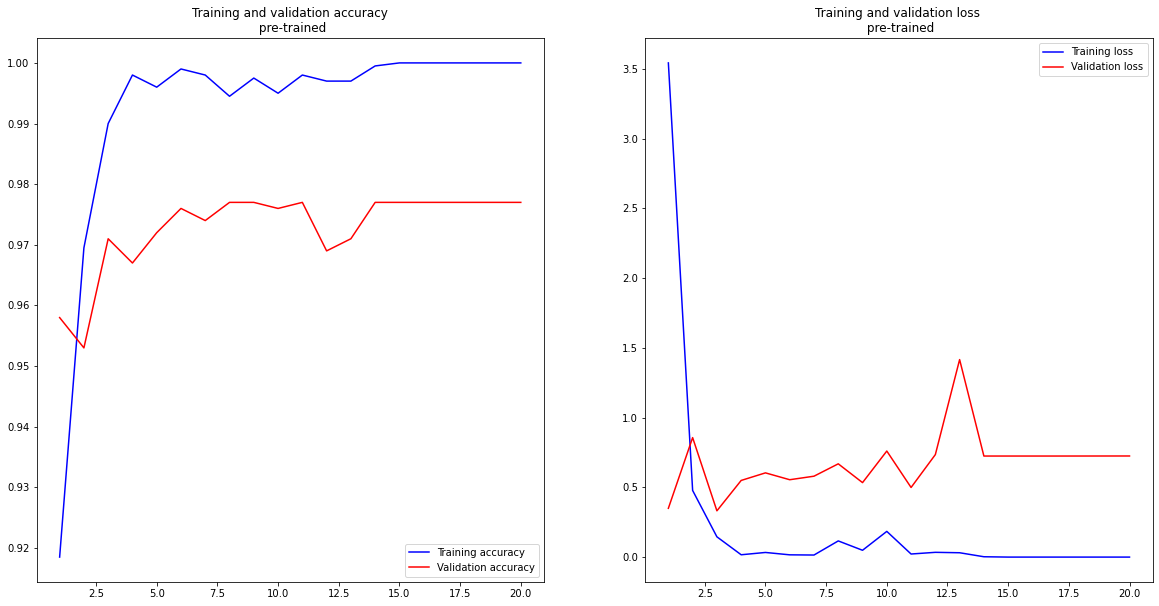

In [33]:
accuracy = history_3.history["accuracy"]
val_accuracy = history_3.history["val_accuracy"]

loss = history_3.history["loss"]
val_loss = history_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy\n pre-trained")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss \n pre-trained")
plt.legend()
plt.show()

In [34]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)

print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 5ms/step - loss: 0.4882 - accuracy: 0.9700
Test accuracy: 0.970


# Feature extraction with data augmentation

<img src="Pretrained-2.jpg" width=800 align="center">

In [28]:
from tensorflow.keras.applications import VGG16 

conv_base = VGG16(include_top=False,
                  weights="imagenet", #using the same weights of the model already done
                  input_shape=(180, 180, 3))

In [29]:
print(f"The number of trainable weights before freezing is {len(conv_base.trainable_weights)}")

conv_base.trainable = False

print(f"The number of trainable weights after freezing is {len(conv_base.trainable_weights)}")

The number of trainable weights before freezing is 26
The number of trainable weights after freezing is 0


In [30]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [26]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(100, activation="softmax")(x)

# x = layers.Flatten()(x)
# x = layers.Dense(256)(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = keras.Model(inputs, outputs)
model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

In [27]:
model_4.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_data_augmentation.keras",
                                            save_best_only=True,
                                            monitor="val_loss")

history_4 = model_4.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=[callbacks])

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 4.4759 - accuracy: 0.8945

KeyboardInterrupt: 

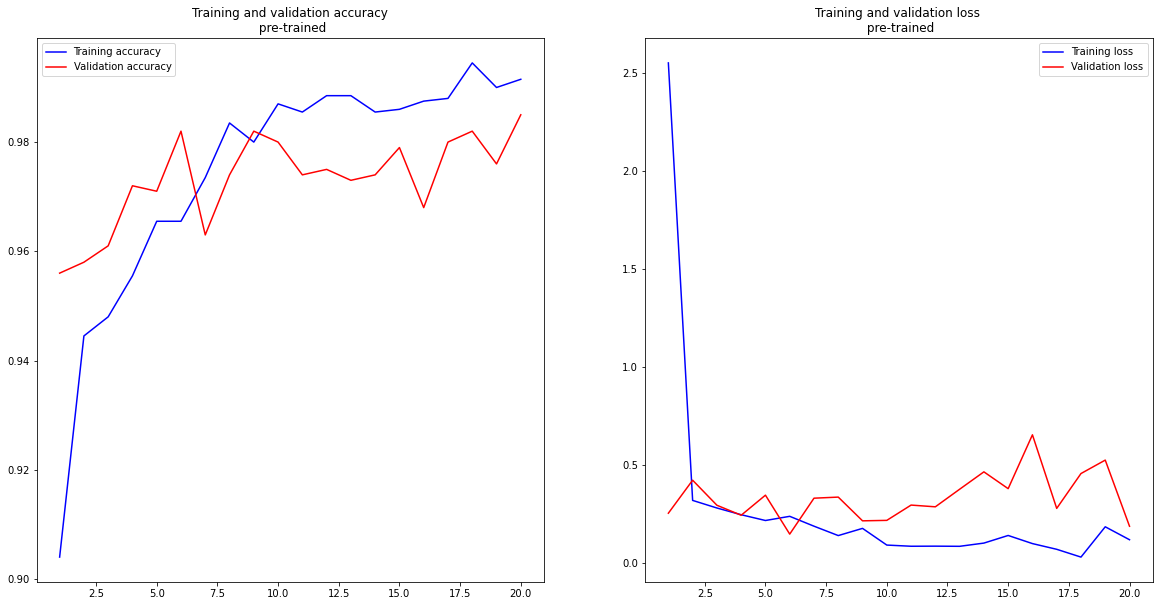

In [23]:
accuracy = history_4.history["accuracy"]
val_accuracy = history_4.history["val_accuracy"]

loss = history_4.history["loss"]
val_loss = history_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy\n pre-trained")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss \n pre-trained")
plt.legend()
plt.show()

In [24]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_ds)

print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 80ms/step - loss: 0.2167 - accuracy: 0.9760
Test accuracy: 0.976


# Fine-tuning

<img src="Pretrained-3.jpg" width=800 align="center">

In [31]:
conv_base.trainable = True
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [26]:
conv_base.layers

In [27]:
for layer in conv_base.layers[:-4]:
    layer.trainable=False
    
for layer in conv_base.layers:
    print(f"Is layer {layer.name} trainable? {layer.trainable}")

Is layer input_3 trainable? False
Is layer block1_conv1 trainable? False
Is layer block1_conv2 trainable? False
Is layer block1_pool trainable? False
Is layer block2_conv1 trainable? False
Is layer block2_conv2 trainable? False
Is layer block2_pool trainable? False
Is layer block3_conv1 trainable? False
Is layer block3_conv2 trainable? False
Is layer block3_conv3 trainable? False
Is layer block3_pool trainable? False
Is layer block4_conv1 trainable? False
Is layer block4_conv2 trainable? False
Is layer block4_conv3 trainable? False
Is layer block4_pool trainable? False
Is layer block5_conv1 trainable? True
Is layer block5_conv2 trainable? True
Is layer block5_conv3 trainable? True
Is layer block5_pool trainable? True


In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [29]:
model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

In [30]:
# Note that here we are recompiling and training the model from the last section
# That is, the model we are fine-tuning

model_4.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

callbacks = keras.callbacks.ModelCheckpoint(filepath="fine_tuning.keras",
                                            save_best_only=True,
                                            monitor="val_loss")

history_5 = model_4.fit(train_ds,
                        epochs=20,
                        validation_data=val_ds,
                        callbacks=[callbacks])

Epoch 1/20
63/63 [==============================] - 10s 143ms/step - loss: 0.0473 - accuracy: 0.9930 - val_loss: 0.1839 - val_accuracy: 0.9860
Epoch 2/20
63/63 [==============================] - 9s 141ms/step - loss: 0.0162 - accuracy: 0.9975 - val_loss: 0.1361 - val_accuracy: 0.9890
Epoch 3/20
63/63 [==============================] - 9s 141ms/step - loss: 0.0158 - accuracy: 0.9970 - val_loss: 0.1400 - val_accuracy: 0.9880
Epoch 4/20
63/63 [==============================] - 9s 141ms/step - loss: 0.0203 - accuracy: 0.9980 - val_loss: 0.1617 - val_accuracy: 0.9830
Epoch 5/20
63/63 [==============================] - 9s 141ms/step - loss: 0.0010 - accuracy: 0.9995 - val_loss: 0.1547 - val_accuracy: 0.9850
Epoch 6/20
63/63 [==============================] - 9s 141ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.1716 - val_accuracy: 0.9840
Epoch 7/20
63/63 [==============================] - 9s 141ms/step - loss: 0.0132 - accuracy: 0.9965 - val_loss: 0.1894 - val_accuracy: 0.9840
Epoch

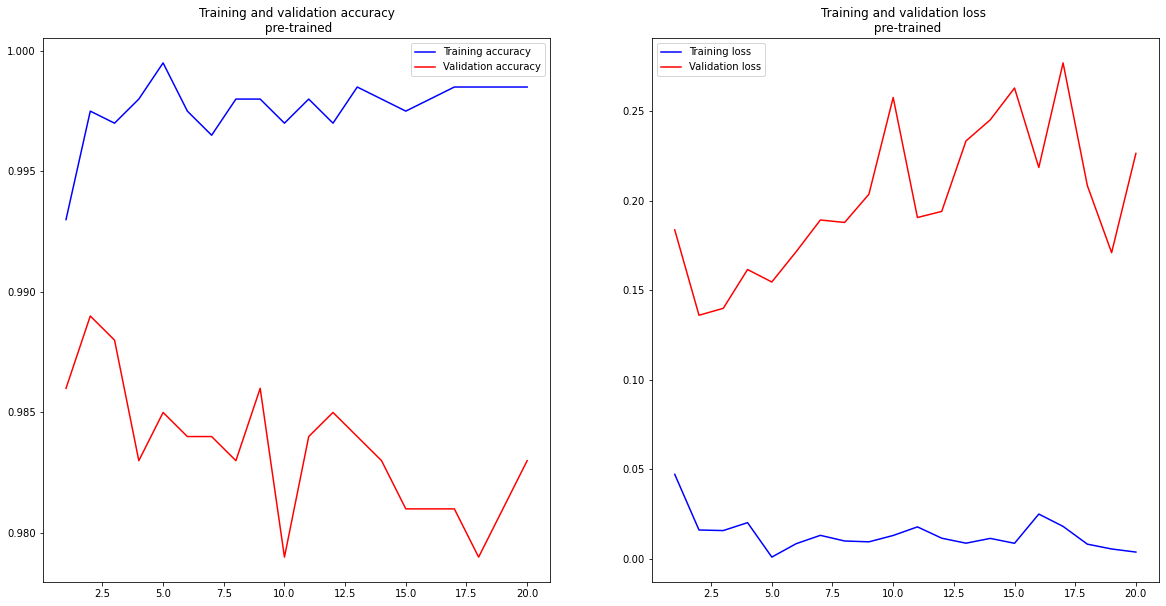

In [31]:
accuracy = history_5.history["accuracy"]
val_accuracy = history_5.history["val_accuracy"]

loss = history_5.history["loss"]
val_loss = history_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy\n pre-trained")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss \n pre-trained")
plt.legend()
plt.show()

In [32]:
model_5 = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model_5.evaluate(test_ds)

print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 82ms/step - loss: 0.3858 - accuracy: 0.9765
Test accuracy: 0.976
